In [1]:
from transformers import pipeline

checkpoint = "google/owlv2-base-patch16-ensemble"
detector = pipeline(model=checkpoint, task="zero-shot-object-detection")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/620M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use mps:0


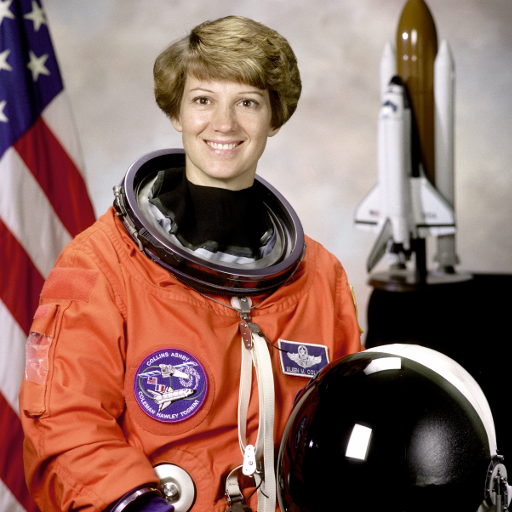

In [2]:
import skimage
import numpy as np
from PIL import Image

image = skimage.data.astronaut()
image = Image.fromarray(np.uint8(image)).convert("RGB")

image

In [3]:
predictions = detector(
    image,
    candidate_labels=["human face", "flag"],
)

In [4]:
predictions

[{'score': 0.5303393602371216,
  'label': 'flag',
  'box': {'xmin': 1, 'ymin': -1, 'xmax': 99, 'ymax': 505}},
 {'score': 0.24360798299312592,
  'label': 'flag',
  'box': {'xmin': 147, 'ymin': 376, 'xmax': 156, 'ymax': 384}},
 {'score': 0.16068460047245026,
  'label': 'flag',
  'box': {'xmin': 7, 'ymin': 0, 'xmax': 512, 'ymax': 506}},
 {'score': 0.13141800463199615,
  'label': 'flag',
  'box': {'xmin': 155, 'ymin': 383, 'xmax': 166, 'ymax': 393}},
 {'score': 0.12506739795207977,
  'label': 'human face',
  'box': {'xmin': 296, 'ymin': 345, 'xmax': 309, 'ymax': 365}}]

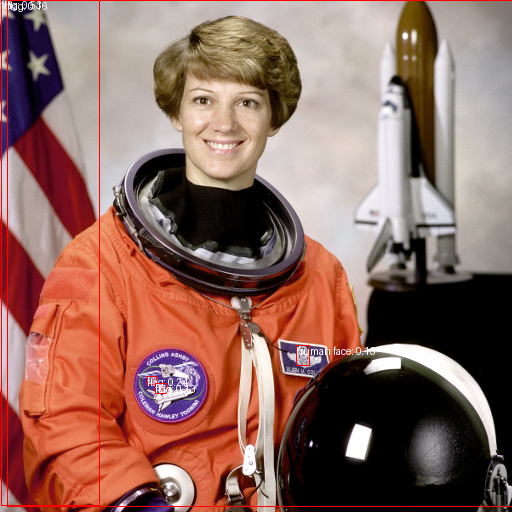

In [5]:
from PIL import ImageDraw

draw = ImageDraw.Draw(image)

for prediction in predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]

    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="white")

image

In [25]:
from transformers import pipeline
import cv2
import numpy as np
from PIL import Image, ImageDraw
import os
from pathlib import Path

def extract_frames(video_path, fps=10):
    """Extract frames from video at specified FPS."""
    cap = cv2.VideoCapture(video_path)
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(original_fps / fps)
    
    frames = []
    frame_count = 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
            
        if frame_count % frame_interval == 0:
            # Convert BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame_rgb)
            
        frame_count += 1
        
        if len(frames) >= 4:  # Get 4 consecutive frames
            yield frames
            frames = []
    
    cap.release()
    if frames:  # Process any remaining frames
        yield frames

def process_frames(video_path, output_dir, threshold=0.5):
    """Process video frames with object detection and save individual frames."""
    # Create output directory if it doesn't exist
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Initialize the detector
    detector = pipeline(
        model="google/owlv2-base-patch16-ensemble",
        task="zero-shot-object-detection"
    )
    
    # Open video to get properties
    cap = cv2.VideoCapture(video_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
    
    frame_number = 0
    
    # Process frames in groups of 4
    for frame_group in extract_frames(video_path):
        for frame in frame_group:
            # Convert numpy array to PIL Image
            pil_image = Image.fromarray(frame)
            
            # Perform detection
            predictions = detector(
                pil_image,
                candidate_labels=["car", "truck", "bus", ],
            )
            
            # Draw bounding boxes and check for warnings
            draw = ImageDraw.Draw(pil_image)
            show_warning = False
            
            for prediction in predictions:
                box = prediction["box"]
                label = prediction["label"]
                score = prediction["score"]
                
                # Calculate box area relative to image area
                box_area = (box["xmax"] - box["xmin"]) * (box["ymax"] - box["ymin"])
                image_area = width * height
                area_ratio = box_area / image_area
                
                # Check if vehicle is too close (large box)
                if area_ratio > threshold and score > 0.3:
                    show_warning = True
                
                # Draw bounding box
                draw.rectangle(
                    (box["xmin"], box["ymin"], box["xmax"], box["ymax"]),
                    outline="red",
                    width=2
                )
                draw.text(
                    (box["xmin"], box["ymin"] - 10),
                    f"{label}: {round(score, 2)}",
                    fill="red"
                )
            
            # Add warning text if needed
            if show_warning:
                draw.text(
                    (10, 10),
                    "WARNING: Vehicle too close!",
                    fill="red"
                )
            
            # Save the processed frame
            frame_path = output_dir / f"frame_{frame_number:06d}.jpg"
            pil_image.save(frame_path, "JPEG", quality=95)
            frame_number += 1
            
            # Print progress
            if frame_number % 10 == 0:
                print(f"Processed {frame_number} frames...")
    
    print(f"Processing complete. Saved {frame_number} frames to {output_dir}")


In [ ]:

def main():
    # input_video = "/Users/khoavo2003/PycharmProjects/DAAD-RISE-Germany/critical_classification/critical_dataset/Car_crash_video/000001.mp4"
    # output_dir = "/Users/khoavo2003/paper_work/duckietown/object_detection_duckietown/processed_frames"
    input_video = ""
    output_dir = ""
    process_frames(input_video, output_dir, threshold=0.3)

In [ ]:
main()

Device set to use mps:0


Processed 10 frames...
Processed 20 frames...
Processed 30 frames...
